### **Figure 6: Sensory and association cortex show distinct age-related changes in myelination network properties**

#### **6.1 Setup**


In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

# Import helper functions
import sys
sys.path.append('code')
from stats_helpers import *
from plotting_helpers import *

#### **6.2 Estimate age-related change in T1w/T2w MIND edges**

Use multiple linear regressions to estimate linear changes in T1w/T2w MIND edges

In [ ]:
# Load MIND edges per subjects
edge_per_subj_df_filt = pd.read_csv('output/subj_dfs/edge_per_subj_filt.csv', index_col=0)

# Retain subjects below 3 years of age to approximate development
edge_dev = edge_per_subj_df_filt[edge_per_subj_df_filt['Age'] < 3]

# Extract edges
edges = edge_dev.columns[4:]

# Run MLR with age and sex as predictors
mlr_results_df = run_mlr(edge_dev, edges, ['Age', 'Sex'])

# Save
mlr_dir = 'output/mlr/'
os.makedirs(mlr_dir, exist_ok=True)

mlr_results_df.to_csv('output/mlr/edge_mlr_results.csv')

100%|██████████| 26335/26335 [00:21<00:00, 1223.98it/s]


Plot b_age matrix, showing linear rate of change in each edge

/Users/EdHutchings_1/proj1/analyses/code/plotting_helpers.py:103: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(mpatches.Rectangle((-3, i), 3, 1, color=row_colors[i], clip_on=False, lw=1, edgecolor='face'))  # Left
/Users/EdHutchings_1/proj1/analyses/code/plotting_helpers.py:104: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(mpatches.Rectangle((i, -3), 1, 3, color=col_colors[i], clip_on=False, lw=1, edgecolor='face'))  # Top


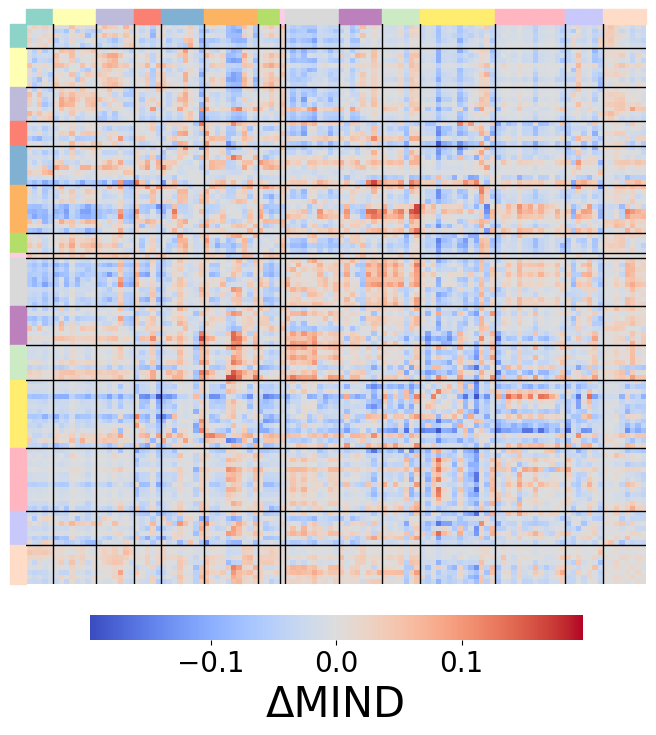

In [3]:
# Load results
mlr_results_df = pd.read_csv('output/mlr/edge_mlr_results.csv', index_col=0)

# Re-format to matrix
n_rois = 230
b_age_mat = np.zeros((n_rois,n_rois))
b_age_mat[np.triu_indices(n_rois, k=1)] = mlr_results_df['b_Age']
b_age_mat = pd.DataFrame(b_age_mat + b_age_mat.T)

# Visualise b_age matrix
matrix_plot(b_age_mat, 
            edge_cmap='coolwarm', diverging=True, 
            cbar_label='ΔMIND', 
            patches=True, boundaries=True, labels=False,
            save_path=None)

#### **6.3 Clustering age-related change matrix**

Use agglomerative clustering to compute clusters of regions with similar patterns of edge-level changes

First, visualise clustered matrix and dendrogram

/Users/EdHutchings_1/proj1/analyses/marm_MIND/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/EdHutchings_1/proj1/analyses/marm_MIND/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


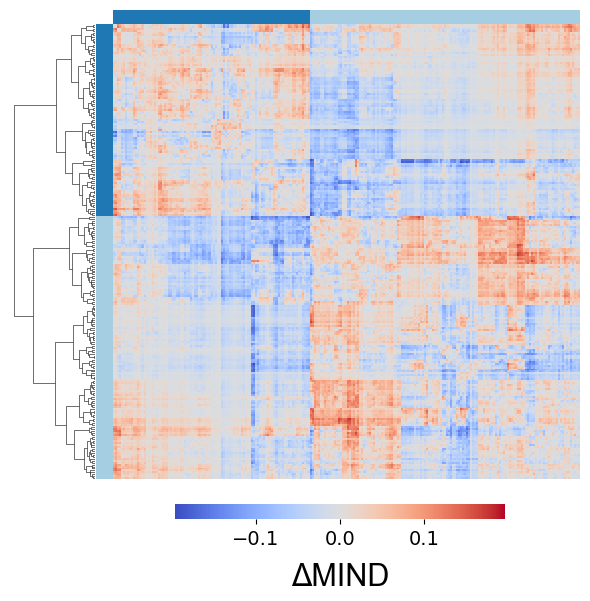

In [ ]:
# Generate colour mapping for clusters
cluster_cmap = {
    0: [0.6510, 0.8078, 0.8902], # Association
    1: [0.1216, 0.4706, 0.7059] # Sensory
}

# Call plotting function
plot_dendrogram_and_matrix(X = b_age_mat.values, 
                           n_clusters=2,
                           cluster_cmap=cluster_cmap, 
                           cbar_label='ΔMIND',
                           save_path=None)

#### **6.4 Biological properties of clusters**

Generate dataframe containing clusters and anatomical properties

Here, each area is assigned an integer from 1 to 6 reflecting its cortical type, with 1 assigned to Agranular (least laminated) and 6 assigned to Koniocortex (most laminated)

In [5]:
# Compute clusters
cluster_labels = hierarchical_clustering(b_age_mat.values, n_clusters=2)

# Load lookup table
lut = pd.read_csv('data/lut_master.csv', index_col=0)

# Dictionary defining mapping from cortical type to degree of lamination
type_to_lamination_mapping = {
    'Agranular': 1,
    'Dysgranular': 2,
    'Eulaminate I': 3,
    'Eulaminate II': 4,
    'Eulaminate III': 5,
    'Koniocortex': 6
}

# Map type to number (degree of lamination)
lut['lamination'] = lut['type'].map(type_to_lamination_mapping)

# Create dataframe for plotting (left hemisphere)
plotting_df = pd.DataFrame({'ROI':lut['Label'][0:115],
                            'lvl':lut['lvl'][0:115], 
                            'lamination':lut['lamination'][0:115],
                            'cluster':cluster_labels[0:115]})

# Dictionary defining mapping from cluster number to cluster name
cluster_num_to_name_mapping = {
        0: 'Sensory',
        1: 'Association',
    }

# Map cluster number to name
plotting_df['cluster_name'] = plotting_df['cluster'].map(cluster_num_to_name_mapping)

# Print number of regions in each cluster (left hemisphere)
print(f"Number of left hemisphere regions in sensory cluster = {plotting_df[plotting_df['cluster'] == 0].shape[0]}")
print(f"Number of left hemisphere regions in association cluster = {plotting_df[plotting_df['cluster'] == 1].shape[0]}")

Number of left hemisphere regions in sensory cluster = 66
Number of left hemisphere regions in association cluster = 49


Compare 1) the mean degree of lamination and 2) the mean hierarchical level of sensory and association clusters using an unpaired t-test. 

Significance is assessed by comparing against the t-statistics computed from 1000 spatial autocorrelation-preserving nulls. Nulls are generated by using BrainSmash (with resample=True) to generate permutations of adult mean T1w/T2w with matched spatial autocorrelation, then applying these permnutations to the empirical cluster assignment map

100%|██████████| 1000/1000 [00:04<00:00, 200.24it/s]
/Users/EdHutchings_1/proj1/analyses/marm_MIND/lib/python3.11/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/Users/EdHutchings_1/proj1/analyses/code/plotting_helpers.py:529: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Assoc', 'Sensory'], fontsize=12, fontfamily='Arial')


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Association vs. Sensory: ***


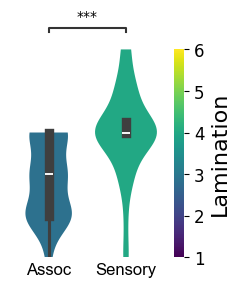

t = 5.762, p = 0.000


In [ ]:
# Distance matrix
dist = pd.read_csv('data/distance_matrix.csv', index_col=0)
dist = dist.iloc[0:115,0:115].values

# Mean adult T1w/T2w
adult_mean_t12 = pd.read_csv('output/T1wT2w/mean/mean_adult_regional_t12.csv', index_col=0)
adult_mean_t12 = adult_mean_t12[adult_mean_t12.columns[0]].values[0:115]

plot_2_cluster_lamination(df=plotting_df, 
                          map=adult_mean_t12, 
                          dist=dist, 
                          surrogates_filename='output/surrogates/mean_adult_t12_surrogates.csv', 
                          n_perm=1000, 
                          test_type='two-tailed',
                          save_path=None)

100%|██████████| 1000/1000 [00:04<00:00, 204.14it/s]
/Users/EdHutchings_1/proj1/analyses/marm_MIND/lib/python3.11/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/Users/EdHutchings_1/proj1/analyses/code/plotting_helpers.py:645: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Assoc', 'Sensory'], fontsize=12, fontfamily='Arial')


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Association vs. Sensory: ***


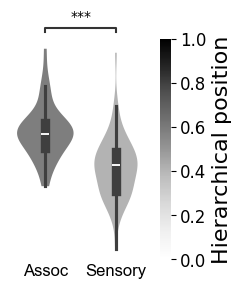

t = -6.402, p = 0.000


In [ ]:
# Distance matrix
dist = pd.read_csv('data/distance_matrix.csv', index_col=0)
dist = dist.iloc[0:115,0:115].values

# Mean adult T1w/T2w
adult_mean_t12 = pd.read_csv('output/T1wT2w/mean/mean_adult_regional_t12.csv', index_col=0)
adult_mean_t12 = adult_mean_t12[adult_mean_t12.columns[0]].values[0:115]

plot_2_cluster_SA_position(df=plotting_df, 
                           map=adult_mean_t12, 
                           dist=dist, 
                           surrogates_filename='output/surrogates/mean_adult_t12_surrogates.csv', 
                           n_perm=1000, 
                           test_type='two-tailed',
                           save_path=None)

Comparing mean T1w/T2w trajectory for each cluster. 

Multiple linear regressions with age and sex as covariates are used to assess the significance of the main effect of age on mean T1w/T2w, then linear trajectories are plotted.

Regression results:


,cluster,intercept,r2,b_Age,p_Age,b_Sex,p_Sex,p_Age_corr,p_Sex_corr
0,0,0.265790,0.055925,0.047325,0.000595,0.011311,0.478781,0.001190,0.957561
1,1,0.220325,0.013951,0.017400,0.091117,0.004803,0.690380,0.182235,1.000000


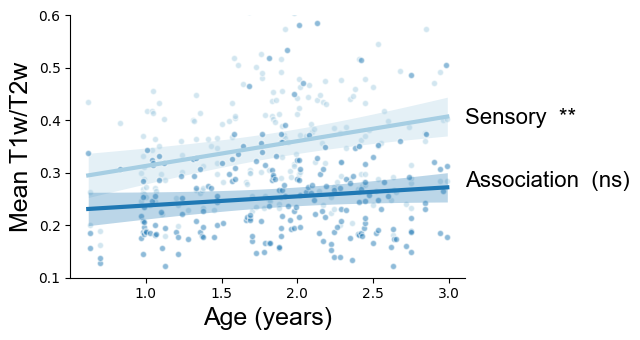

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load data
mean_t12_per_subj_df_filt = pd.read_csv('output/subj_dfs/mean_t12_per_subj_filt.csv', index_col=0)

# Keep only developmental subjects (< 3 yrs)
mean_t12_dev = mean_t12_per_subj_df_filt[mean_t12_per_subj_df_filt['Age'] < 3]

# Number of clusters
n_clusters = 2

# Initialise df to hold results per cluster
results = []

# Set figure size
plt.figure(figsize=(6.5,3.5))

# Loop clusters
for i in range(n_clusters):
    
    # Mean T1w/T2w per cluster per subject
    cluster_mean = mean_t12_dev.iloc[:, 4:].iloc[:, cluster_labels == i].mean(axis=1)
    
    # ----- Run MLR ----- #

    # Build dataframe for statsmodels
    df_cluster = mean_t12_dev[['Age', 'Sex']].copy()
    df_cluster['cluster_mean'] = cluster_mean.values
    
    # Multiple linear regression: cluster_mean ~ Age + Sex
    model = smf.ols("cluster_mean ~ Age + Sex", data=df_cluster).fit()
    
    # Store results
    results.append({
        'cluster': i,
        'intercept': model.params['Intercept'],
        'r2': model.rsquared,
        'b_Age': model.params['Age'],
        'p_Age': model.pvalues['Age'],
        'b_Sex': model.params['Sex'],
        'p_Sex': model.pvalues['Sex'],
    })
    

    # ----- Plotting ----- #

    x_grid = np.linspace(df_cluster['Age'].min(), df_cluster['Age'].max(), 200)
    sex_fixed = 0  # Plot trajectory for Sex = 0, i.e. for females
    pred_df = pd.DataFrame({'Age': x_grid, 'Sex': sex_fixed})
    pred = model.get_prediction(pred_df).summary_frame(alpha=0.05)
    
    y_pred = pred['mean'].values
    ci_lo  = pred['mean_ci_lower'].values
    ci_hi  = pred['mean_ci_upper'].values
    
    # Scatter raw data
    plt.scatter(
        df_cluster['Age'], df_cluster['cluster_mean'],
        color=list(cluster_cmap.values())[i], alpha=0.5, s=20, edgecolors='w'
    )
    
    # Regression line
    plt.plot(
        x_grid, y_pred,
        color=list(cluster_cmap.values())[i],
        linewidth=3
    )
    
    # 95% CI
    plt.fill_between(
        x_grid, ci_lo, ci_hi,
        color=list(cluster_cmap.values())[i], alpha=0.3, linewidth=0
    )

# Multiple comparisons correction
results_df = pd.DataFrame(results)
results_df['p_Age_corr'] = multipletests(results_df['p_Age'], method='Bonferroni')[1]
results_df['p_Sex_corr'] = multipletests(results_df['p_Sex'], method='Bonferroni')[1]

# Display results
print('Regression results:')
display(results_df)


# ----- Formatting plot ----- #

plt.ylim([0.1, 0.6])
plt.xlabel('Age (years)', fontsize=18, fontfamily='Arial')
plt.ylabel('Mean T1w/T2w', fontsize=18, fontfamily='Arial')
for spine in ['right', 'top']:
    plt.gca().spines[spine].set_visible(False)

# Establish coordinates for annotion
x_annot = plt.gca().get_xlim()[1] * 1   # a bit outside the x-axis
y_min, y_max = plt.gca().get_ylim()
y_positions = np.linspace(y_max * 0.675, y_max * 0.475, n_clusters)  # spread annotations vertically

# Annotate with p-values
for i in range(n_clusters):
    p_corr = results_df.loc[i, 'p_Age_corr']

    if p_corr < 0.001:
        p_text = '***'
    elif p_corr < 0.01:
        p_text = '**'
    elif p_corr < 0.05:
        p_text = '*'
    else:
        p_text = '(ns)'

    plt.text(
        x_annot, y_positions[i],
        f'{cluster_num_to_name_mapping[i]}  {p_text}',
        fontsize=16,
        fontfamily='Arial',
        ha='left', va='center'
    )

plt.tight_layout()
plt.show()